### Lesson 03 - First Neural Network

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
import seaborn as sns
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix

In [5]:
# Loading the data

ROOT_DIR = 'MNIST'

train_data = datasets.MNIST(
    root = ROOT_DIR,
    train = True,
    transform = transforms.ToTensor(),
    target_transform = None,
    download = True   
)

test_data = datasets.MNIST(
    root = ROOT_DIR,
    train = False,
    transform = transforms.ToTensor(),
    target_transform = None,
    download = True   
)

100.0%


Extracting MNIST\MNIST\raw\train-images-idx3-ubyte.gz to MNIST\MNIST\raw



100.0%


Extracting MNIST\MNIST\raw\train-labels-idx1-ubyte.gz to MNIST\MNIST\raw



100.0%


Extracting MNIST\MNIST\raw\t10k-images-idx3-ubyte.gz to MNIST\MNIST\raw



100.0%

Extracting MNIST\MNIST\raw\t10k-labels-idx1-ubyte.gz to MNIST\MNIST\raw



In [6]:
train_data.data.shape

torch.Size([60000, 28, 28])

In [7]:
test_data.data.shape

torch.Size([10000, 28, 28])

In [8]:
BATCH=128

train_data_loader = DataLoader(dataset=train_data, 
                               batch_size=BATCH, 
                               shuffle=True)

test_data_loader = DataLoader(dataset=test_data, 
                              batch_size=BATCH)

In [9]:
for x in test_data_loader:
    print(x[0].shape)
    print(x[1].shape)    
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])


In [10]:
DEVICE = "cuda" if torch.cuda.is_available() else 'cpu'
DEVICE

'cpu'

In [11]:
# Lets define the model

class NeuralNetwork(nn.Module):
    def __init__(self, in_, out_):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, out_)
        )
        
    def forward(self, x):
        return self.layers(x)

In [12]:
model = NeuralNetwork(784, 10)

model.to(DEVICE)

model

NeuralNetwork(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [13]:
model.parameters()

<generator object Module.parameters at 0x000001F6BB6F4BA0>

In [14]:
CE_loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [15]:
# Training loop
EPOCHS = 10
loss_ = list()
acc_ = list()


for epoch in range(EPOCHS):
    print(f"Epoch: {epoch + 1}/{EPOCHS}")
    for batch, data in enumerate(train_data_loader):
        x = data[0].to(DEVICE)
        y = data[1].to(DEVICE)
        
        optimizer.zero_grad()
        
        y_pred = model(x.reshape(-1, 784))
        
        loss = CE_loss(y_pred, y)
        
        loss_.append(loss.item())
        loss.backward()
        optimizer.step()
        
        accuracy = torch.mean((torch.argmax(y_pred, 1) == y).float()).item()
        acc_.append(accuracy)
        
        if batch%100 == 0:
            print(f"   Batch: {batch}, Loss: {loss.item():.4f} Accuracy {accuracy:.4f}")

Epoch: 1/10
   Batch: 0, Loss: 2.3067 Accuracy 0.0391
   Batch: 100, Loss: 0.4360 Accuracy 0.9062
   Batch: 200, Loss: 0.2292 Accuracy 0.9141
   Batch: 300, Loss: 0.1334 Accuracy 0.9609
   Batch: 400, Loss: 0.1808 Accuracy 0.9531
Epoch: 2/10
   Batch: 0, Loss: 0.1838 Accuracy 0.9688
   Batch: 100, Loss: 0.1537 Accuracy 0.9531
   Batch: 200, Loss: 0.0859 Accuracy 0.9766
   Batch: 300, Loss: 0.1520 Accuracy 0.9453
   Batch: 400, Loss: 0.0500 Accuracy 0.9844
Epoch: 3/10
   Batch: 0, Loss: 0.1151 Accuracy 0.9609
   Batch: 100, Loss: 0.0743 Accuracy 0.9609
   Batch: 200, Loss: 0.1099 Accuracy 0.9609
   Batch: 300, Loss: 0.0396 Accuracy 0.9844
   Batch: 400, Loss: 0.0972 Accuracy 0.9609
Epoch: 4/10
   Batch: 0, Loss: 0.0990 Accuracy 0.9688
   Batch: 100, Loss: 0.0335 Accuracy 1.0000
   Batch: 200, Loss: 0.0902 Accuracy 0.9688
   Batch: 300, Loss: 0.1190 Accuracy 0.9688
   Batch: 400, Loss: 0.0659 Accuracy 0.9688
Epoch: 5/10
   Batch: 0, Loss: 0.0406 Accuracy 0.9844
   Batch: 100, Loss: 0.052

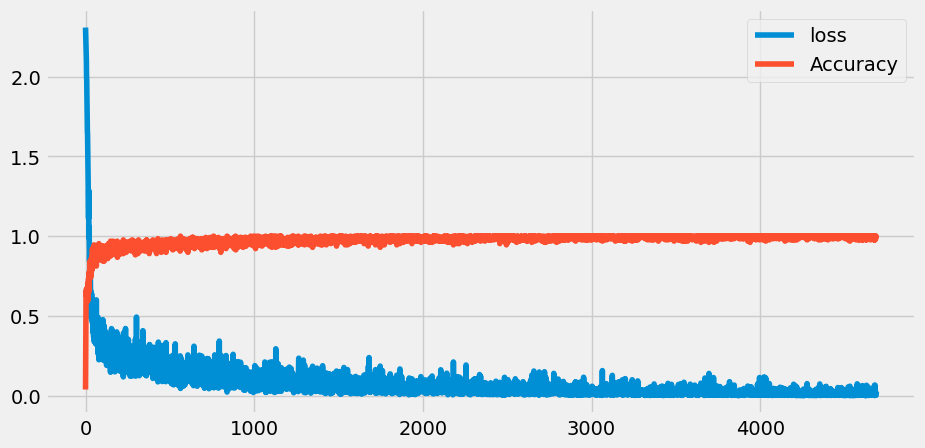

In [16]:
# plot the Train acc and loss
pd.DataFrame(data={'loss': loss_, "Accuracy": acc_}).plot(figsize=(10,5))
plt.show()

In [17]:
# testing over the test data

test_loss = 0
test_acc = 0

with torch.no_grad():
    for batch, data in enumerate(test_data_loader):
        x = data[0].to(DEVICE)
        y = data[1].to(DEVICE)        
        
        y_pred = model(x.reshape(-1, 784))
        loss = CE_loss(y_pred, y)
        
        test_loss += loss.item()
        test_acc += torch.mean((torch.argmax(y_pred, 1) == y).float()).item()
        batch+=1

In [18]:
print(f"test loss: {test_loss/batch:.4f}, test accuracy: {test_acc/batch:.4f}")

test loss: 0.0686, test accuracy: 0.9824


In [19]:
pred = np.array([])
target = np.array([])

with torch.no_grad():
    for batch, data in enumerate(test_data_loader):
        x = data[0].to(DEVICE)
        y = data[1].to(DEVICE)        
        
        y_pred = model(x.reshape(-1, 784))
        loss = CE_loss(y_pred, y)
        
        pred = np.concatenate((pred, torch.argmax(y_pred, 1).cpu().numpy()))
        target = np.concatenate((target, y.cpu().numpy()))

In [20]:
cm = confusion_matrix(target, pred)

In [21]:
cm

array([[ 968,    1,    2,    0,    1,    0,    5,    1,    1,    1],
       [   0, 1128,    1,    0,    0,    0,    2,    0,    4,    0],
       [   3,    1, 1009,    1,    1,    0,    2,    6,    9,    0],
       [   1,    0,    4,  984,    0,    1,    0,    3,   11,    6],
       [   0,    1,    1,    0,  971,    0,    6,    0,    0,    3],
       [   2,    0,    0,    8,    2,  870,    2,    1,    5,    2],
       [   0,    2,    1,    1,    2,    5,  945,    0,    2,    0],
       [   0,    5,    6,    0,    4,    0,    0, 1008,    1,    4],
       [   1,    0,    2,    3,    5,    0,    2,    2,  956,    3],
       [   2,    2,    0,    1,   11,    2,    1,    5,    2,  983]],
      dtype=int64)

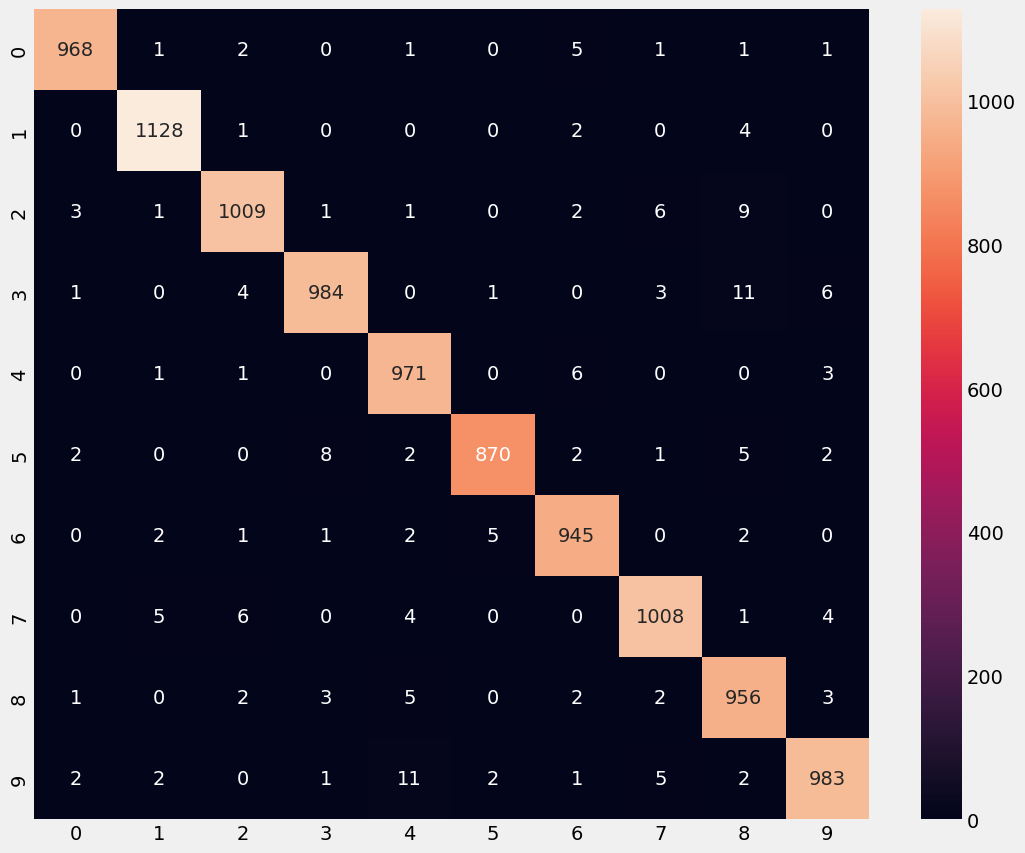

In [22]:
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d')
plt.show()